In [38]:
# import sys
# sys.path.append("../../utils")
from utils.generate_field import *
from utils.visualize import *
# from visualize import *
import numpy as np
from pathlib import Path
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as tick

result_dir = '/home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/5_validation'
nk=3

# HPC Options ['Fermi', ]
server = 'Fermi'

if server=='Fermi':
    ic_dir = '/home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/inputs/'

In [39]:
# recent result
recent_dir = result_dir + r'/outputs'

dir = recent_dir

In [40]:
dims = [128, 128, 64]
domain = [2*np.pi, np.pi, 1]
x_coords, y_coords, z_coords = xyz(domain, dims)
dx = x_coords[1]- x_coords[0]

In [41]:
# filename of different varaibles
theta_f = dir + r'/theta.%.2i.%.8i'
velocity_f = dir + r'/baseflow/u_base.%.8i'

# Validation

## Initial and boundary conditions
Validation based on previous literature{cite}`kimTransportPassiveScalars1989`. The setup of initial and boundary conditions in the original paper are
$$
\begin{aligned}
&\theta_i (x, y, z, 0) = 0.5(1-y^2)\\
& \theta_i (x, -1, z, t) = 0, \quad \theta_i (x, 1, z, t) = 0
\end{aligned}
$$


However, in LESGO, the normal direction is $z$ instead of $y$ and the simulation is running on a half channel. So that the transformed IC and BCs are
$$
\begin{aligned}
&\theta_i (x, \hat{y}, \hat{z}, 0) = 0.5(2\hat{z} - \hat{z}^2 )\\
& \theta_i (x, \hat{y}, \hat{z}=0, t) = 0, \quad \frac{\partial \theta_i}{\partial \hat{z}} (x, \hat{y}, \hat{z}=1, t) = 0
\end{aligned}
$$
which is based on 
$$
\hat{z} = y+1,\quad \forall y \in [-1, 0] \quad \& \quad \hat{y} = z, \quad\forall z \in [0, \pi].
$$

In [42]:
data_f = r'/home/zyou6474/Projects/ERI/notebooks/lesgo/tests/Kim_data.txt'

z_kim = []
data = []
tmp = []
x_tmp = []
with open(data_f) as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n', '')
        if line.startswith('%DATA'):
            if len(tmp)>1: data.append(tmp); z_kim.append(x_tmp)
            tmp = []
            x_tmp = []
            continue
        d = line.split(', ')
        x_tmp.append(float(d[0]))
        tmp.append(float(d[1]))

In [43]:
Pr_list = [0.1, 0.71, 2]
Re = 180
RePr = Re*np.array(Pr_list)

Shape of xx: (128, 128, 64)


Text(0, 0.5, 'T')

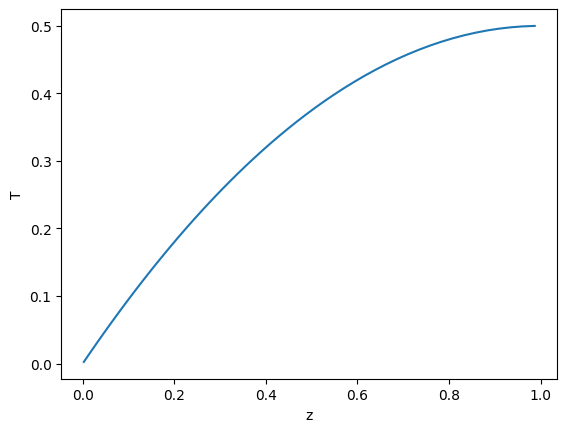

In [44]:
dims = [128, 128, 64]
domain = [2*np.pi, np.pi, 1]
x, y, z = xyz(domain, dims)
xc, yc, zc = XYZ(domain, dims)

theta = 0.5 * (2*zc - zc**2)
fig, ax = plt.subplots()
ax.plot(z, theta[0, 0, :])
ax.set_xlabel('z')
ax.set_ylabel('T')

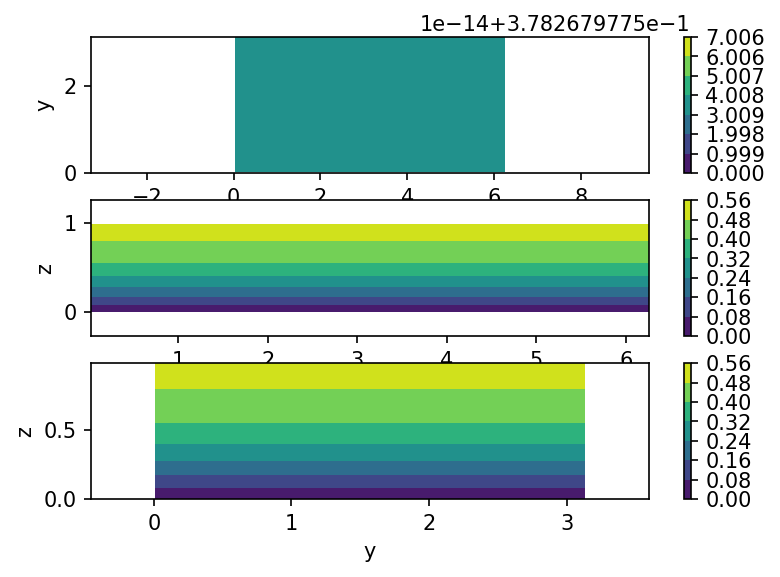

In [45]:
path = ic_dir + 'validation1_128_128_64'
Path(path).mkdir(parents=True, exist_ok=True)
fig = write_array_to_file(path + '/theta.IC.01', theta, gen_fig=True, domain=domain, dims=dims, mu_L=np.array([0.5, 0.5, 0.5]))
fig = write_array_to_file(path + '/theta.IC.02', theta, gen_fig=False, domain=domain, dims=dims, mu_L=np.array([0.5, 0.5, 0.5]))
fig = write_array_to_file(path + '/theta.IC.03', theta, gen_fig=False, domain=domain, dims=dims, mu_L=np.array([0.5, 0.5, 0.5]))


## Source

According to Kim's work{cite}`kimTransportPassiveScalars1989`, they also has a continuous source term inside the channel, 
$$
\begin{equation}
Q_i = \frac{2}{\text{Re}\text{Pr}_i}.
\end{equation}
$$

In [46]:
source = []

for Pr in Pr_list:
    source.append(zc*0 + 2/Re/Pr)
    print('%.4f amount of scalar is generated at each point' % (2/Re/Pr))

0.1111 amount of scalar is generated at each point
0.0156 amount of scalar is generated at each point
0.0056 amount of scalar is generated at each point


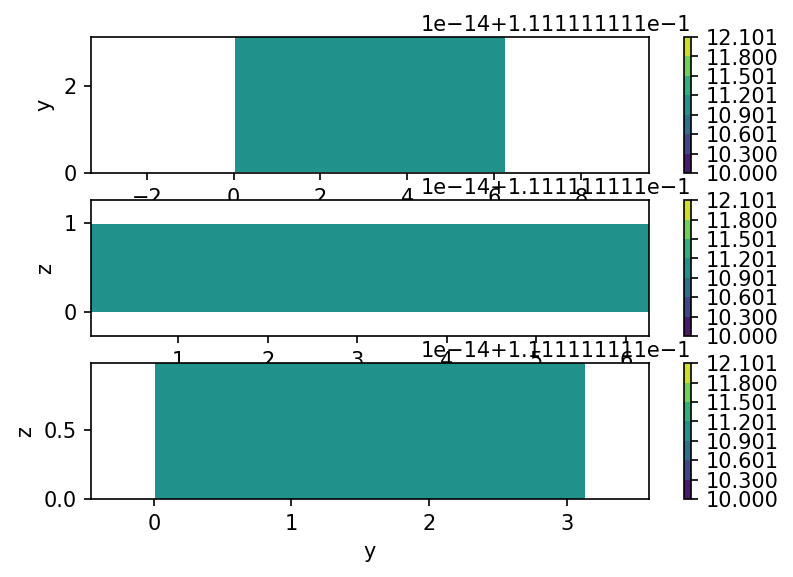

In [47]:
path = ic_dir + 'validation1_128_128_64'
Path(path).mkdir(parents=True, exist_ok=True)
fig = write_array_to_file(path + '/source.01', source[0], gen_fig=True, domain=domain, dims=dims, mu_L=np.array([0.5, 0.5, 0.5]))
fig = write_array_to_file(path + '/source.02', source[1], gen_fig=False, domain=domain, dims=dims, mu_L=np.array([0.5, 0.5, 0.5]))
fig = write_array_to_file(path + '/source.03', source[2], gen_fig=False, domain=domain, dims=dims, mu_L=np.array([0.5, 0.5, 0.5]))


## Validate with previous data
Compare with the profile in literature.

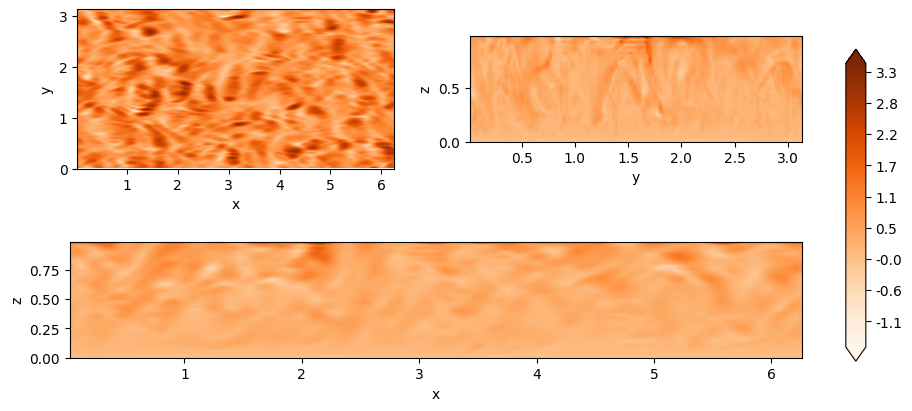

In [48]:
t_ind = 5000

theta = read_array_from_file(theta_f % (nk, int(t_ind)), dims)

fig, ax = contourf_xyz(domain, dims, theta)

In [49]:
theta_bar = np.mean(theta, axis=(0, 1))
theta_gradient = (theta_bar[1] - theta_bar[0])/(z[1]-z[0])
theta_tau = theta_gradient/RePr[nk-1]

z_plus = z*Re
theta_plus = theta_bar /theta_tau

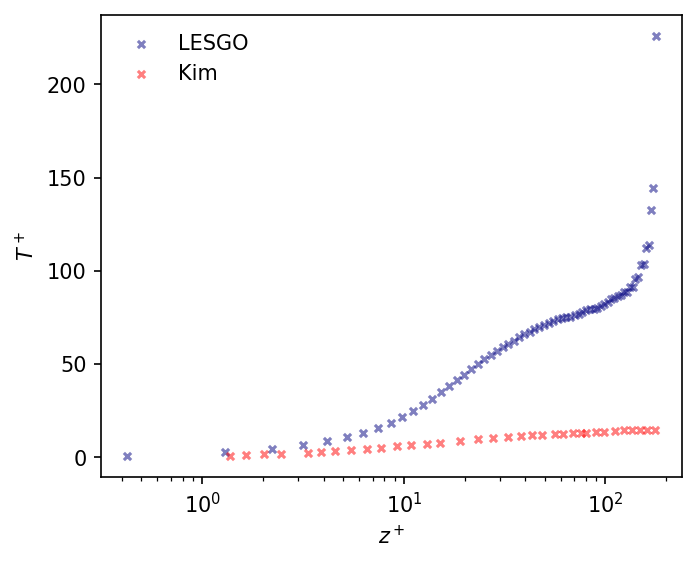

In [50]:
fig, ax = plt.subplots(figsize = (5, 4), dpi=150)
ax.scatter(z_plus, theta_plus, s= 12, marker='x', color='navy', alpha=0.5, label='LESGO')
ax.scatter(z_kim[0], data[0], s= 12, marker='x', color='red', alpha=0.5, label='Kim')

ax.legend(frameon=False)
ax.set_xlabel('$z^+$')
ax.set_ylabel('$T^+$')
ax.set_xscale('log')